이 노트북을 코랩에서 실행하려면 Pro 버전이 필요할 수 있습니다.

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/06_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=6)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 560, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 560 (delta 177), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (560/560), 48.74 MiB | 13.30 MiB/s, done.
Resolving deltas: 100% (276/276), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.26.1
Using datasets v2.10.1
Using accelerate v0.16.0
Using sentencepiece v0.1.97
Using sacrebleu v2.3.1
Using rouge_score
Using nltk v3.7
Using py7zr v0.20.4


In [2]:
from transformers import pipeline, set_seed

# 요약

## CNN/DailyMail 데이터셋

In [3]:
from datasets import load_dataset

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("cnn_dailymail", version="3.0.0") 
print(f"특성: {dataset['train'].column_names}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

특성: ['article', 'highlights', 'id']


In [4]:
sample = dataset["train"][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events. Here,
Soledad O'Brien takes users inside a jail where many of the inmates are mentally
ill. An inmate housed on the "forgotten floor," where many mentally ill inmates
are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the
Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here,
inmates with the most s

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


## 텍스트 요약 파이프라인

In [5]:
sample_text = dataset["train"][1]["article"][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장합니다.
summaries = {}

In [6]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### 요약 기준 모델

In [8]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [9]:
summaries["baseline"] = three_sentence_summary(sample_text)

### GPT-2

In [10]:
from transformers import pipeline, set_seed

set_seed(42)

# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생합니다.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.
pipe = pipeline("text-generation", model="gpt2-xl")

gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


### T5

<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_t5.png?raw=1" id="T5"/>

In [11]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### BART

In [12]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### PEGASUS

<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_pegasus.png?raw=1" id="pegasus"/>

In [13]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

## 요약 결과 비교하기

In [14]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are
mentally ill. An inmate housed on the "forgotten floor," where many mentally ill
inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention
facility is dubbed the "forgotten floor."

GPT2
- Miami-Dade jails have more mentally ill inmates than other counties - About
one-third of the mentally ill in Miami-Dade county are housed here - All the
mentally ill prisoners have no shoes, no beds, and no mattresse

## 생성된 텍스트 품질 평가하기

### BLEU

In [15]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

<ipython-input-15-eacc06f6d0e4>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [16]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [17]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROUGE

In [18]:
rouge_metric = load_metric("rouge")

In [19]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.275229,0.093458,0.201835,0.275229
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


## CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

In [20]:
# 이 셀은 노트북 중간부터 실행하기 위한 것입니다.
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("cnn_dailymail", version="3.0.0") 
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article", 
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])    
    score = metric.compute()
    return score

In [22]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [23]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [24]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, 
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 125/125 [07:47<00:00,  3.74s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434759,0.216742,0.312271,0.374631


In [25]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434759,0.216742,0.312271,0.374631


## 요약 모델 훈련하기

In [26]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


### SAMSum에서 PEGASUS 평가하기

In [27]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [28]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])




  0%|          | 0/103 [00:00<?, ?it/s]


  1%|          | 1/103 [00:03<06:04,  3.57s/it]


  2%|▏         | 2/103 [00:06<05:23,  3.21s/it]


  3%|▎         | 3/103 [00:10<05:42,  3.43s/it]


  4%|▍         | 4/103 [00:14<05:54,  3.58s/it]


  5%|▍         | 5/103 [00:16<05:16,  3.23s/it]


  6%|▌         | 6/103 [00:20<05:28,  3.39s/it]


  7%|▋         | 7/103 [00:24<05:36,  3.50s/it]


  8%|▊         | 8/103 [00:27<05:30,  3.48s/it]


  9%|▊         | 9/103 [00:29<04:56,  3.15s/it]


 10%|▉         | 10/103 [00:33<05:07,  3.31s/it]


 11%|█         | 11/103 [00:36<04:47,  3.12s/it]


 12%|█▏        | 12/103 [00:40<05:01,  3.32s/it]


 13%|█▎        | 13/103 [00:43<04:58,  3.31s/it]


 14%|█▎        | 14/103 [00:46<05:00,  3.37s/it]


 15%|█▍        | 15/103 [00:50<05:06,  3.49s/it]


 16%|█▌        | 16/103 [00:54<05:09,  3.56s/it]


 17%|█▋        | 17/103 [00:57<05:05,  3.55s/it]


 17%|█▋        | 18/103 [01:00<04:39,  3.29s/it]


 18%|█▊        | 19/103 [01:03<04:30,  3.22s/i

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


In [29]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


### PEGASUS 미세 튜닝하기

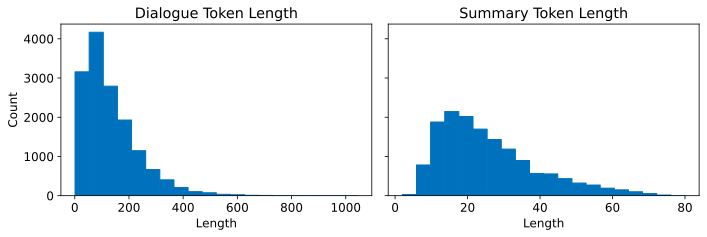

In [30]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [31]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [32]:
# 티처 포싱(teacher forcing)
# 텍스트 생성을 위한 디코더 입력과 레이블의 정렬
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [33]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [34]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [35]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [36]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

Cloning https://huggingface.co/haesun/pegasus-samsum into local empty directory.


Download file pytorch_model.bin:   0%|          | 7.43k/2.13G [00:00<?, ?B/s]

Download file runs/Sep03_10-06-51_fb108a177a1e/events.out.tfevents.1662200558.fb108a177a1e.365.0:  90%|#######…

Download file runs/Sep19_14-24-46_0757b01a1c66/events.out.tfevents.1663598435.0757b01a1c66.78.0:  44%|####3   …

Download file runs/Sep03_07-11-01_26606349e738/events.out.tfevents.1662190833.26606349e738.77.0: 100%|########…

Download file runs/Sep03_10-06-51_fb108a177a1e/1662200558.9387803/events.out.tfevents.1662200558.fb108a177a1e.…

Download file runs/Sep19_14-24-46_0757b01a1c66/1663598435.556187/events.out.tfevents.1663598435.0757b01a1c66.7…

Download file runs/Aug01_03-31-25_default/events.out.tfevents.1659324691.default.493.0:  44%|####3     | 8.27k…

Clean file runs/Sep03_10-06-51_fb108a177a1e/events.out.tfevents.1662200558.fb108a177a1e.365.0:   5%|5         …

Clean file runs/Sep03_07-11-01_26606349e738/events.out.tfevents.1662190833.26606349e738.77.0:   5%|5         |…

Clean file runs/Sep03_10-06-51_fb108a177a1e/1662200558.9387803/events.out.tfevents.1662200558.fb108a177a1e.365…

Clean file runs/Sep19_14-24-46_0757b01a1c66/events.out.tfevents.1663598435.0757b01a1c66.78.0:   5%|5         |…

Download file spiece.model:   1%|          | 17.0k/1.82M [00:00<?, ?B/s]

Clean file runs/Sep19_14-24-46_0757b01a1c66/1663598435.556187/events.out.tfevents.1663598435.0757b01a1c66.78.1…

Clean file runs/Aug01_03-31-25_default/events.out.tfevents.1659324691.default.493.0:   5%|5         | 1.00k/18…

Download file runs/Sep03_07-11-01_26606349e738/1662190833.3421242/events.out.tfevents.1662190833.26606349e738.…

Clean file runs/Sep03_07-11-01_26606349e738/1662190833.3421242/events.out.tfevents.1662190833.26606349e738.77.…

Download file runs/Aug01_03-31-25_default/1659324691.6091912/events.out.tfevents.1659324691.default.493.1: 100…

Clean file runs/Aug01_03-31-25_default/1659324691.6091912/events.out.tfevents.1659324691.default.493.1:  19%|#…

Download file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

Download file runs/Aug01_02-16-35_default/1659320203.0345788/events.out.tfevents.1659320203.default.183.1: 100…

Download file runs/Aug01_02-16-35_default/events.out.tfevents.1659320203.default.183.0: 100%|##########| 3.73k…

Clean file training_args.bin:  30%|###       | 1.00k/3.30k [00:00<?, ?B/s]

Download file runs/Aug01_02-16-35_default/1659321148.5612001/events.out.tfevents.1659321148.default.183.3: 100…

Clean file runs/Aug01_02-16-35_default/1659320203.0345788/events.out.tfevents.1659320203.default.183.1:  23%|#…

Clean file runs/Aug01_02-16-35_default/events.out.tfevents.1659320203.default.183.0:  27%|##6       | 1.00k/3.…

Clean file runs/Aug01_02-16-35_default/1659321148.5612001/events.out.tfevents.1659321148.default.183.3:  23%|#…

Download file runs/Aug01_02-16-35_default/events.out.tfevents.1659321148.default.183.2: 100%|##########| 40.0/…

Clean file runs/Aug01_02-16-35_default/events.out.tfevents.1659321148.default.183.2: 100%|##########| 40.0/40.…

Clean file spiece.model:   0%|          | 1.00k/1.82M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/2.13G [00:00<?, ?B/s]

In [37]:
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, dialogue, id. If summary, dialogue, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__ca

{'loss': 3.2203, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.0848, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 3.1048, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 3.0867, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.7972, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.8491, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.8246, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.6051, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.4961, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.2691, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.2506, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.12}
{'loss': 2.1764, 'learning_rate': 1.2e-05, 'epoch': 0.13}
{'loss': 2.2938, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.14}
{'loss': 2.1686, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.15}
{'loss': 2.0737, 'learning_rate': 1.5e-05, 'epoch': 0.16}
{'loss': 2.0694, 'learni

The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, dialogue, id. If summary, dialogue, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 1


{'loss': 1.7008, 'learning_rate': 5e-05, 'epoch': 0.54}
{'eval_loss': 1.4825782775878906, 'eval_runtime': 32.4171, 'eval_samples_per_second': 25.234, 'eval_steps_per_second': 25.234, 'epoch': 0.54}
{'loss': 1.75, 'learning_rate': 4.880952380952381e-05, 'epoch': 0.55}
{'loss': 1.6476, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.56}
{'loss': 1.7058, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.58}
{'loss': 1.7114, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.59}
{'loss': 1.6977, 'learning_rate': 4.404761904761905e-05, 'epoch': 0.6}
{'loss': 1.6247, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.61}
{'loss': 1.5827, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.62}
{'loss': 1.6214, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.63}
{'loss': 1.6072, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.64}
{'loss': 1.5803, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.65}
{'loss': 1.5756, 'learning_rate': 3.690476190476191e-05, 'epoch': 0.66}
{'loss': 1.5



Training completed. Do not forget to share your model on huggingface.co/models =)




{'loss': 1.6045, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 2002.2713, 'train_samples_per_second': 7.358, 'train_steps_per_second': 0.459, 'train_loss': 1.8293617352195408, 'epoch': 1.0}


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

  6%|▋         | 26/410 [00:31<07:36,  1.19s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "max_length": 128,
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

  7%|▋         | 27/410 [00:32<07:26,  1.17s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "max_length": 128,
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

  7%|▋         | 28/410 [00:33<07:21,  1.15s/it]Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "m

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.428623,0.197787,0.340182,0.340287


In [38]:
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.428623,0.197787,0.340182,0.340287


In [39]:
trainer.push_to_hub("Training complete!")

Saving model checkpoint to pegasus-samsum
Configuration saved in pegasus-samsum/config.json
Configuration saved in pegasus-samsum/generation_config.json
Model weights saved in pegasus-samsum/pytorch_model.bin
tokenizer config file saved in pegasus-samsum/tokenizer_config.json
Special tokens file saved in pegasus-samsum/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/2.13G [00:00<?, ?B/s]

Upload file runs/Mar06_05-09-12_339c74aee749/1678080543.9792733/events.out.tfevents.1678080543.339c74aee749.59…

Upload file training_args.bin: 100%|##########| 3.37k/3.37k [00:00<?, ?B/s]

Upload file runs/Mar06_05-09-12_339c74aee749/events.out.tfevents.1678080543.339c74aee749.5951.0: 100%|########…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/haesun/pegasus-samsum
   44169e7..1de5b60  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/haesun/pegasus-samsum
   44169e7..1de5b60  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'samsum', 'type': 'samsum', 'config': 'samsum', 'split': 'validation', 'args': 'samsum'}}
To https://huggingface.co/haesun/pegasus-samsum
   1de5b60..17b6f9f  main -> main

   1de5b60..17b6f9f  main -> main



'https://huggingface.co/haesun/pegasus-samsum/commit/1de5b608710e159c7dc15397c64ba2ed61313cb6'

### 대화 요약 생성하기

In [40]:
import transformers
transformers.logging.set_verbosity_error()

In [41]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
pipe = pipeline("summarization", model="haesun/pegasus-samsum")

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

참조 요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.

모델 요약:
Amanda can't find Betty's number. Larry called Betty last time they were at the
park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


In [42]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis and Leandro are going to write a book about transformers. Thom
helped build a library by Hugging Face. They are going to do it together.


## 결론